# Network descriptive statistics
In this notebook, I'll explore descriptive statistics and analyses about my citation network(s). This will include things like topic modelling in addition to more simple statistics. For the moment, I'm going to work with the Semantic Scholar dataset, so statistics about citations should be taken with a grain of salt.

In [51]:
import jsonlines
import requests
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import networkx as nx
import re
import gensim
from gensim.utils import simple_preprocess
import nltk
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords
import gensim.corpora as corpora
import pyLDAvis
import pyLDAvis.gensim_models
from langdetect import detect
import spacy

[nltk_data] Downloading package stopwords to
[nltk_data]     /mnt/home/lotrecks/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mnt/home/lotrecks/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
2023-11-30 11:30:49.157600: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/tensorflow/python/framework/dtypes.py:246: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: (False, True),
/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/s

In [3]:
# Import API key. This must be requested from https://www.semanticscholar.org/product/api#api-key; we save ours in an untracked file in data and import here
import sys
sys.path.append('../data/')
from semantic_scholar_API_key import API_KEY
header = {'x-api-key': API_KEY}

## Reading in the dataset

In [4]:
with jsonlines.open('../data/semantic_scholar/desiccation_tolerance_10000_with_reference_abstracts_19Sep2023.jsonl') as reader:
    papers = []
    for obj in reader:
        papers.append(obj)

In [5]:
# Wrangling into a flattened object with paperID as indexer to eliminate redundant papers for analyses where we don't
# care about the connectivity of the network
flattened_papers = {}
for p in papers:
    try:
        flattened_papers[p['paperId']] = {'title': p['title'], 'abstract': p['abstract']}
    except KeyError:
        flattened_papers[p['paperId']] = {'title': p['title']}
    for r in p['references']:
        try:
            flattened_papers[r['paperId']] = {'title': r['title'], 'abstract': r['abstract']}
        except KeyError:
            flattened_papers[r['paperId']] = {'title': r['title']}

In [6]:
# Using old classification from before generic bugfix for the moment
classified = nx.read_graphml('../data/citation_network/full_10000_with_classification_gen_terms_debug_15Nov2023.graphml')

In [7]:
paper_classifications = {k: v['study_system'] for k, v in classified.nodes(data=True)}

## Simple descriptive statistics
### Number of papers

In [8]:
print(f'There are {len(flattened_papers)} unique papers in the dataset')

There are 192506 unique papers in the dataset


In [9]:
# Check the overlap between both sets
len(set(paper_classifications)), len(set(flattened_papers.keys()).intersection(set(paper_classifications)))

(192505, 192505)

### Number of papers per year
I didn't grab the years in my initial retrieval; will do this now

In [10]:
num_batches = len(flattened_papers)//500 + 1
num_batches, num_batches*500

(386, 193000)

In [11]:
to_retrieve = list(flattened_papers.keys())

In [12]:
papers_with_years = []
for i in range(num_batches):
    ids = to_retrieve[i*500:(i+1)*500]
    succeeded = False
    while not succeeded:
        r = requests.post(
            'https://api.semanticscholar.org/graph/v1/paper/batch',
            params={'fields': 'year'},
            json={"ids": ids},
            headers=header
        ).json()
        if type(r) == list:
            succeeded = True
        else:
            print(f'Request number {i} failed, trying again')
    papers_with_years.extend(r)  

Request number 108 failed, trying again
Request number 195 failed, trying again
Request number 377 failed, trying again


In [13]:
len(papers_with_years)

192506

In [14]:
len([p for p in papers_with_years if p is None])

116

In [15]:
paper_years = [p['year'] for p in papers_with_years if (p is not None) and (p['year'] is not None)]

In [16]:
len(paper_years)

191575

Text(0, 0.5, 'Count')

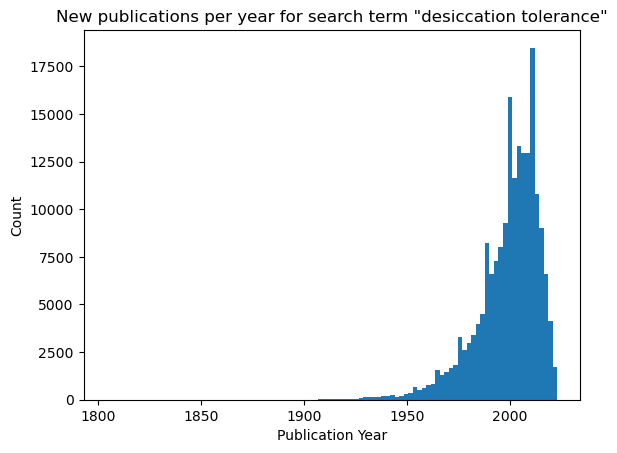

In [17]:
_ = plt.hist(paper_years, bins=100)
plt.title('New publications per year for search term "desiccation tolerance"')
plt.xlabel('Publication Year')
plt.ylabel('Count')

Here we can see that the field of desiccation tolerance research really started to take off around 1950. What does the total publications over time look like?

In [18]:
counts_per_year = Counter(paper_years)

In [19]:
ordered_years = sorted(counts_per_year.keys())

In [20]:
cumulative_years = {y:(ordered_years[i] + sum(ordered_years[:i]))/1000 for i, y in enumerate(ordered_years)}

Text(0.5, 0, 'Year')

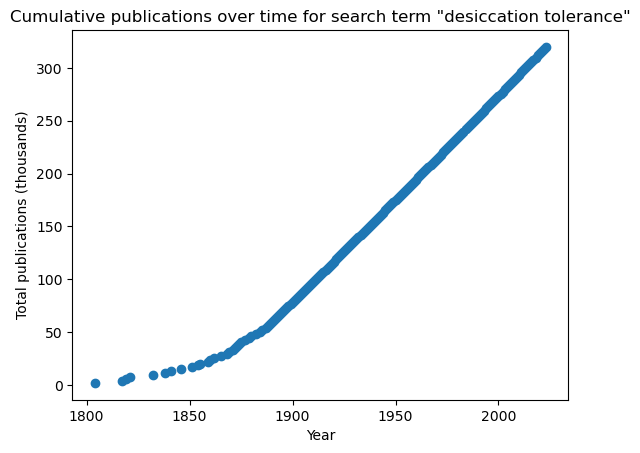

In [21]:
plt.scatter(cumulative_years.keys(), cumulative_years.values())
plt.title('Cumulative publications over time for search term "desiccation tolerance"')
plt.ylabel('Total publications (thousands)')
plt.xlabel('Year')

What does this look like if we subset by the classification that we have?

In [22]:
len(set(paper_classifications.keys()).intersection(set([p['paperId'] for p in papers_with_years if p is not None])))

186628

There are papers in the year dataset that don't match up with any `paperId` in the classification set. I believe this is due to [paper merging](https://github.com/allenai/s2-folks/issues/157); however, I am unaware of a way to get back the paperId's that I started with. For now, I'm going to move on with intersection, with the awareness that ~6,000 papers here are missing .

In [23]:
# Add the classifications to the dataset
for p in papers_with_years:
    if p is not None:
        try:
            p['classification'] = paper_classifications[p['paperId']]
        except KeyError:
#             p['classification'] = 'missing_in_new'
            continue

In [24]:
# Separate by classification
years_per_class = defaultdict(list)
for p in papers_with_years:
    if p is not None:
        if p['year'] is not None:
            try:
                years_per_class[p['classification']].append(p['year'])
            except KeyError:
                continue

In [25]:
years_per_class.keys()

dict_keys(['Plant', 'Animal', 'NOCLASS', 'Microbe', 'Fungi'])

We want to look both at the normal and cumulative versions:

In [26]:
colors = {'Plant': '#E69F00', 'Animal': '#56B4E9', 'Microbe': '#009E73', 'Fungi': '#F0E442', 'NOCLASS': '#CC79A7', 'missing_in_new': '#C7C7C7'}

Text(0, 0.5, 'Count')

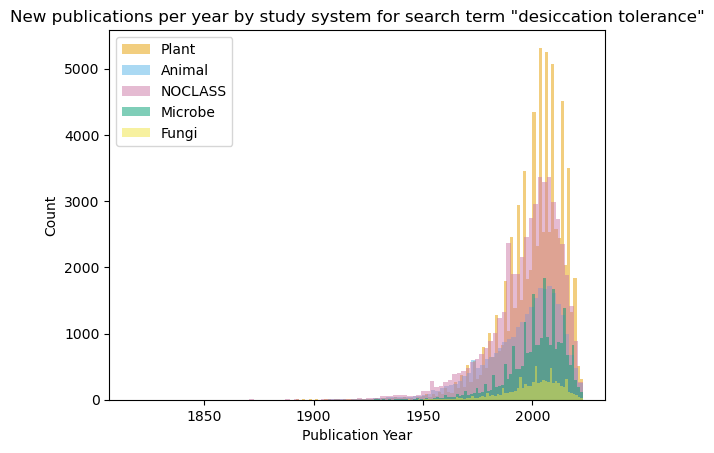

In [27]:
fig, ax = plt.subplots(1, 1)
for cls, yrs in years_per_class.items():
    _ = ax.hist(yrs, bins=100, color=colors[cls], label=cls, alpha=0.5)
plt.legend()
plt.title('New publications per year by study system for search term "desiccation tolerance"')
plt.xlabel('Publication Year')
plt.ylabel('Count')

The distributions look the same, which is great! Now let's look at the cumulative:

Text(0.5, 0, 'Year')

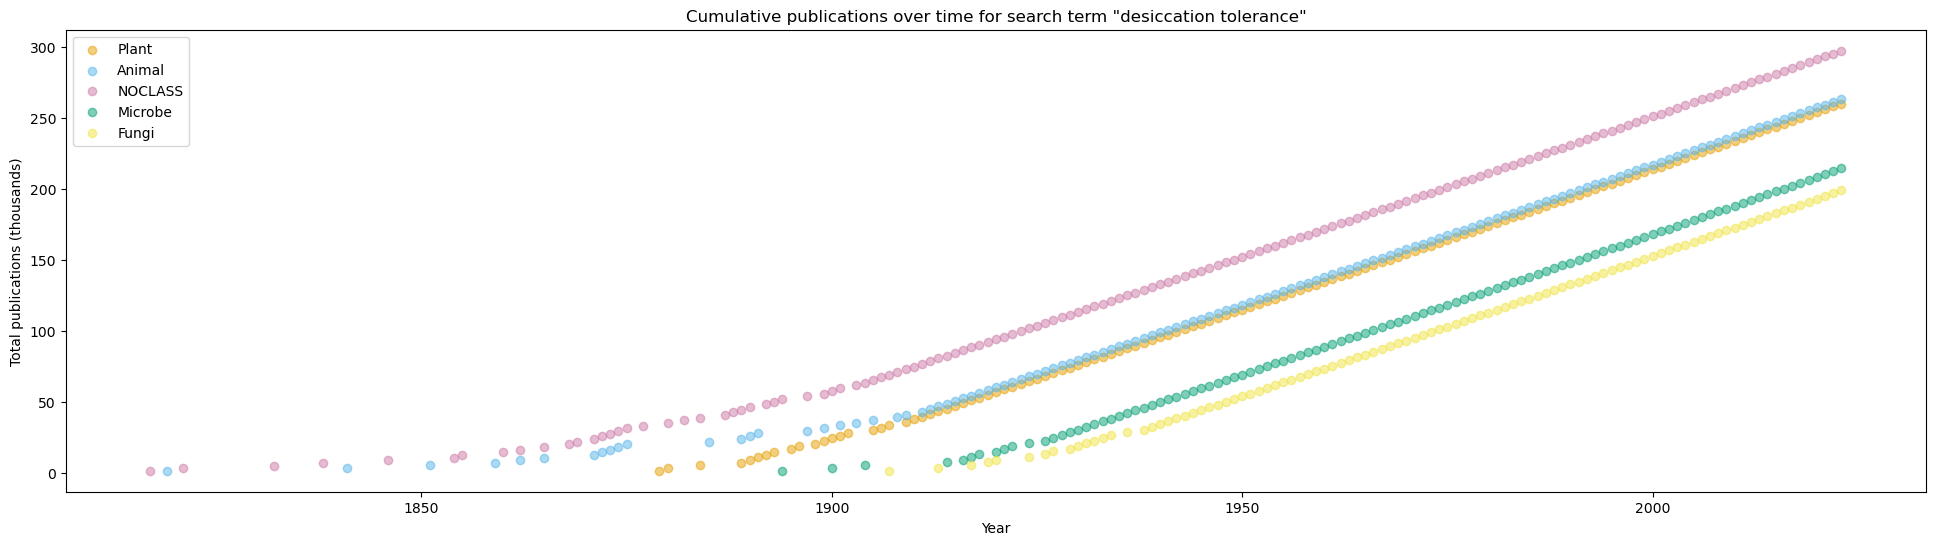

In [28]:
fig, ax = plt.subplots(1, 1, figsize=(24,6))
for cls, yrs in years_per_class.items():
    yr_counts = Counter(yrs)
    ordered_yrs = sorted(yr_counts.keys())
    cumulative_years = {y:(ordered_yrs[i] + sum(ordered_yrs[:i]))/1000 for i, y in enumerate(ordered_yrs)}
    ax.scatter(cumulative_years.keys(), cumulative_years.values(), color=colors[cls], alpha=0.5, label=cls)
plt.legend()
plt.title('Cumulative publications over time for search term "desiccation tolerance"')
plt.ylabel('Total publications (thousands)')
plt.xlabel('Year')

I wouldn't have expected plant and animal to have such similar numbers! Again, `NOCLASS` and `missing_in_new` are accounting for such a large portion here that we have to take these with a grain of salt, but I still think this is promising.

## Topic modeling
We can perform topic modeling on titles and abstracts to get a better sense of what's in our dataset. We followed [this tutorial](https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0) to get started; however, since our results didn't make a ton of sense compared to what we actually observed in the dataset, we're going to implement some suggestions from [another tutorial](https://towardsdatascience.com/6-tips-to-optimize-an-nlp-topic-model-for-interpretability-20742f3047e2) to try and improve the usefulness of our results.

In [29]:
for_df_papers = defaultdict(list)
for pid, p in flattened_papers.items():
    for_df_papers['paperId'].append(pid)
    for_df_papers['title'].append(p['title'])
    try:
        for_df_papers['abstract'].append(p['abstract'])
    except KeyError:
        for_df_papers['abstract'].append(None)
paper_df = pd.DataFrame.from_dict(for_df_papers)

In [30]:
paper_df.head()

,paperId,title,abstract
0,393cc126bd647a8435072e788a2a033561c6fa97,Unexplored dimensions of variability in vegeta...,Desiccation tolerance has evolved recurrently ...
1,18d8e54e9f384361d3f6af634642e82d2479bef2,Expression dynamics of dehydration tolerance i...,Tolerance to prolonged water deficit occurs al...
2,2ee8adf45800831679c9ee226cf108b34197108b,Multi‐Omics Insights into the Evolution of Ang...,None
3,af0eb5272536c8b1db53e671b77d9ea61e206ff5,All for One: The Role of Colony Morphology in ...,"In the last decade, several works showed that ..."
4,2b32eec751dbe123a7532cfac4fb3c8ce5295a37,Desiccation Tolerance in Chlorophyllous Fern S...,Fern spores of most species are desiccation to...


In [31]:
# From tutorial
# Remove punctuation
paper_df['title_processed'] = paper_df['title'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
paper_df['title_processed'] = paper_df['title_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
paper_df['title_processed'].head()

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/local/26668502/ipykernel_40281/3669035623.py:3: DeprecationWarning: invalid escape sequence '\.'
  paper_df['title_processed'] = paper_df['title'].map(lambda x: re.sub('[,\.!?]', '', x))


0    unexplored dimensions of variability in vegeta...
1    expression dynamics of dehydration tolerance i...
2    multi‐omics insights into the evolution of ang...
3    all for one: the role of colony morphology in ...
4    desiccation tolerance in chlorophyllous fern s...
Name: title_processed, dtype: object

In [32]:
papers_with_abstracts = paper_df[~paper_df['abstract'].isna()].copy()

In [33]:
# From tutorial
# Remove punctuation
papers_with_abstracts['abstract_processed'] = papers_with_abstracts['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))
# Convert the titles to lowercase
papers_with_abstracts['abstract_processed'] = papers_with_abstracts['abstract_processed'].map(lambda x: x.lower())
# Print out the first rows of papers
papers_with_abstracts['abstract_processed'].head()

<>:3: DeprecationWarning: invalid escape sequence '\.'
<>:3: DeprecationWarning: invalid escape sequence '\.'
/tmp/local/26668502/ipykernel_40281/2512256173.py:3: DeprecationWarning: invalid escape sequence '\.'
  papers_with_abstracts['abstract_processed'] = papers_with_abstracts['abstract'].map(lambda x: re.sub('[,\.!?]', '', x))


0    desiccation tolerance has evolved recurrently ...
1    tolerance to prolonged water deficit occurs al...
3    in the last decade several works showed that e...
4    fern spores of most species are desiccation to...
5    abstract rabarimanarivo mn b ramandimbisoa nh ...
Name: abstract_processed, dtype: object

In [34]:
# stop_words = stopwords.words('english')
# def sent_to_words(sentences):
#     for sentence in sentences:
#         # deacc=True removes punctuations
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
# def remove_stopwords(texts):
#     return [[word for word in simple_preprocess(str(doc)) 
#              if word not in stop_words] for doc in texts]

In [82]:
titles = paper_df.title_processed.values.tolist()
# Use scispacy to lemmatize words
nlp = spacy.load("en_core_sci_sm", disable=['parser', 'ner'])
titles_words = list(sent_to_words(titles))
titles_words = [nlp(' '.join(sent)) for sent in remove_stopwords(titles_words)]
titles_words = [[token.lemma_ for token in title] for title in titles_words]
titles_words_df = pd.DataFrame({'titles':titles_words})

Next cells are from the second tutorial:

In [83]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
finder = nltk.collocations.BigramCollocationFinder.from_documents([comment for comment in titles_words_df.titles])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
bigram_scores = finder.score_ngrams(bigram_measures.pmi)

In [84]:
trigram_measures = nltk.collocations.TrigramAssocMeasures()
finder = nltk.collocations.TrigramCollocationFinder.from_documents([comment for comment in titles_words_df.titles])
# Filter only those that occur at least 50 times
finder.apply_freq_filter(50)
trigram_scores = finder.score_ngrams(trigram_measures.pmi)

In [85]:
bigram_pmi = pd.DataFrame(bigram_scores)
bigram_pmi.columns = ['bigram', 'pmi']
bigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [86]:
trigram_pmi = pd.DataFrame(trigram_scores)
trigram_pmi.columns = ['trigram', 'pmi']
trigram_pmi.sort_values(by='pmi', axis = 0, ascending = False, inplace = True)

In [87]:
# Filter for bigrams with only noun-type structures
def bigram_filter(bigram):
    tag = nltk.pos_tag(bigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['NN']:
        return False
    if bigram[0] in stop_words or bigram[1] in stop_words:
        return False
    if 'n' in bigram or 't' in bigram:
        return False
    if '-PRON-' in bigram:
        return False
    return True
# Filter for trigrams with only noun-type structures
def trigram_filter(trigram):
    tag = nltk.pos_tag(trigram)
    if tag[0][1] not in ['JJ', 'NN'] and tag[1][1] not in ['JJ','NN']:
        return False
    if trigram[0] in stop_words or trigram[-1] in stop_words or trigram[1] in stop_words:
        return False
    if 'n' in trigram or 't' in trigram:
         return False
    if '-PRON-' in trigram:
        return False
    return True 

In [88]:
# Can set pmi threshold to whatever makes sense - eyeball through and select threshold where n-grams stop making sense
# choose top 500 ngrams in this case ranked by PMI that have noun like structures
filtered_bigram = bigram_pmi[bigram_pmi.apply(lambda bigram:\
                                              bigram_filter(bigram['bigram'])\
                                              and bigram.pmi > 5, axis = 1)][:500]

filtered_trigram = trigram_pmi[trigram_pmi.apply(lambda trigram: \
                                                 trigram_filter(trigram['trigram'])\
                                                 and trigram.pmi > 5, axis = 1)][:500]


bigrams = [' '.join(x) for x in filtered_bigram.bigram.values if len(x[0]) > 2 or len(x[1]) > 2]
trigrams = [' '.join(x) for x in filtered_trigram.trigram.values if len(x[0]) > 2 or len(x[1]) > 2 and len(x[2]) > 2]

In [89]:
# Concatenate n-grams
def replace_ngram(x):
    for gram in trigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    for gram in bigrams:
        x = x.replace(gram, '_'.join(gram.split()))
    return x

In [90]:
titles_w_ngrams = titles_words_df.copy()
titles_w_ngrams['titles'] = titles_w_ngrams['titles'].str.join(' ')
titles_w_ngrams.titles = titles_w_ngrams.titles.map(lambda x: replace_ngram(x))

In [91]:
titles_w_ngrams.head()

,titles
0,unexplored dimension variability vegetative de...
1,expression dynamic dehydration tolerance tropi...
2,multi omic insight evolution angiosperm resurr...
3,one role colony morphology bryophyte desiccati...
4,desiccation tolerance chlorophyllous fern spor...


In [105]:
# tokenize reviews + remove stop words + remove names + remove words with less than 2 characters
titles_w_ngrams = titles_w_ngrams.titles.map(lambda x: [word for word in x.split()\
                                                 if word not in stop_words\
#                                                               and word not in english_names\
                                                              and len(word) > 2])

In [106]:
# Filter for only nouns
def noun_only(x):
    pos_comment = nltk.pos_tag(x)
    filtered = [word[0] for word in pos_comment if word[1] in ['NN']]
    # to filter both noun and verbs
    #filtered = [word[0] for word in pos_comment if word[1] in ['NN','VB', 'VBD', 'VBG', 'VBN', 'VBZ']]
    return filtered

In [107]:
final_titles = titles_w_ngrams.map(noun_only)

In [108]:
final_titles

0          [dimension, variability, desiccation, tolerance]
1         [expression, dehydration, tolerance, plant, ma...
2                 [insight, evolution, resurrection, plant]
3         [role, colony, morphology, bryophyte, desiccat...
4         [desiccation, tolerance, spore, feature, condi...
                                ...                        
192501    [effect, catalase, recovery, heat, injure, dna...
192502    [sensitivity, cold, escherichia_coli, relation...
192503                          [formation, medium, oxygen]
192504    [effect, chlorine, spore, clostridium, biferme...
192505         [ozone, future, application, food, industry]
Name: titles, Length: 192506, dtype: object

In [93]:
# abstracts = papers_with_abstracts.abstract_processed.values.tolist()
# abstracts_words = list(sent_to_words(abstracts))
# abstracts_words = remove_stopwords(abstracts_words)
# abstracts_words[0]

In [109]:
# Create Dictionary
id2word_titles = corpora.Dictionary(titles_words_for_modeling)
# Create Corpus
texts_titles = titles_words_for_modeling
# Term Document Frequency
corpus_titles = [id2word_titles.doc2bow(text) for text in texts_titles]
# View
print(corpus_titles[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1)]


In [ ]:
doc_term_matrix = [id2word_titles.doc2bow(doc) for doc in final_titles]
coherence = []
for k in range(5,25):
    print('Round: '+str(k))
    Lda = gensim.models.ldamodel.LdaModel
    ldamodel = Lda(doc_term_matrix, num_topics=k, \
               id2word = id2word_titles, passes=40,\
               iterations=200, chunksize = 10000, eval_every = None)
    
    cm = gensim.models.coherencemodel.CoherenceModel(\
         model=ldamodel, texts=final_titles,\
         dictionary=id2word_titles, coherence='c_v')   
                                                
    coherence.append((k,cm.get_coherence()))

Round: 5
Round: 6
Round: 7
Round: 8
Round: 9


In [110]:
# # Create Dictionary
# id2word_abstracts = corpora.Dictionary(abstracts_words)
# # Create Corpus
# texts_abstracts = abstracts_words
# # Term Document Frequency
# corpus_abstracts = [id2word_abstracts.doc2bow(text) for text in texts_abstracts]
# # View
# print(corpus_abstracts[:1][0][:30])

In [111]:
# number of topics
num_topics = 10
# Build LDA model
lda_model_titles = gensim.models.LdaMulticore(corpus=corpus_titles,
                                       id2word=id2word_titles,
                                       num_topics=num_topics)

In [112]:
# Print the Keyword in the 10 topics
print(lda_model_titles.print_topics())
doc_lda_titles = lda_model_titles[corpus_titles]

[(0, '0.014*"plant" + 0.010*"stress" + 0.008*"seed" + 0.008*"water" + 0.006*"cell" + 0.006*"effect" + 0.006*"salt" + 0.005*"growth" + 0.005*"tolerance" + 0.005*"analysis"'), (1, '0.008*"plant" + 0.007*"change" + 0.007*"soil" + 0.007*"response" + 0.005*"stress" + 0.005*"role" + 0.005*"study" + 0.005*"effect" + 0.004*"specie" + 0.004*"protein"'), (2, '0.013*"plant" + 0.009*"change" + 0.008*"stress" + 0.007*"response" + 0.007*"effect" + 0.006*"protein" + 0.006*"cell" + 0.005*"root" + 0.005*"growth" + 0.005*"arabidopsis"'), (3, '0.014*"protein" + 0.014*"stress" + 0.011*"effect" + 0.009*"plant" + 0.007*"gene" + 0.006*"response" + 0.006*"arabidopsis" + 0.005*"drought" + 0.005*"acid" + 0.005*"evolution"'), (4, '0.009*"effect" + 0.008*"plant" + 0.007*"tolerance" + 0.006*"stress" + 0.005*"acid" + 0.005*"protein" + 0.005*"response" + 0.005*"gene" + 0.005*"seed" + 0.004*"analysis"'), (5, '0.010*"analysis" + 0.009*"effect" + 0.007*"gene" + 0.006*"plant" + 0.005*"cell" + 0.005*"expression" + 0.005*

In [113]:
# # number of topics
# num_topics = 10
# # Build LDA model
# lda_model_abstracts = gensim.models.LdaMulticore(corpus=corpus_abstracts,
#                                        id2word=id2word_abstracts,
#                                        num_topics=num_topics)

In [114]:
# # Print the Keyword in the 10 topics
# print(lda_model_abstracts.print_topics())
# doc_lda_abstracts = lda_model_abstracts[corpus_abstracts]

In [115]:
lda_display_titles = pyLDAvis.gensim_models.prepare(lda_model_titles, corpus_titles, id2word_titles)
pyLDAvis.display(lda_display_titles)

In [101]:
# lda_display_abstracts = pyLDAvis.gensim_models.prepare(lda_model_abstracts, corpus_abstracts, id2word_abstracts)
# pyLDAvis.display(lda_display_abstracts)